In [185]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [75]:
stations = pd.read_csv('station.csv')

In [76]:
trips = pd.read_csv('trip_train.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True, low_memory=False)

In [77]:
weather = pd.read_csv('weather.csv', parse_dates=['date'], infer_datetime_format=True)

In [78]:
stations.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013


In [79]:
trips['start_time'] = trips.start_date.dt.hour
trips['start_date'] = pd.to_datetime(trips.start_date.dt.date)

In [80]:
trips.rename(columns = {'start_date':'date'}, inplace=True)

In [81]:
trips.sample()

,id,duration,date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code,start_time
171851,794450,615,2015-06-04,Embarcadero at Bryant,54,2015-06-04 17:14:00,San Francisco Caltrain (Townsend at 4th),70,623,Subscriber,94066,17


In [82]:
d = {'city': ['San Jose','Redwood City','Mountain View', 'Palo Alto', 'San Francisco'],\
         'zip_code':[95113,94063,94041,94301,94107]}
city_zip_codes = pd.DataFrame(data = d)
city_zip_codes

,city,zip_code
0,San Jose,95113
1,Redwood City,94063
2,Mountain View,94041
3,Palo Alto,94301
4,San Francisco,94107


In [83]:
stations = pd.merge(stations, city_zip_codes, on='city', how='left')
stations

,id,name,lat,long,dock_count,city,installation_date,zip_code
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,8/6/2013,95113
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,8/5/2013,95113
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,8/6/2013,95113
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,8/5/2013,95113
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,8/7/2013,95113
5,7,Paseo de San Antonio,37.333798,-121.886943,15,San Jose,8/7/2013,95113
6,8,San Salvador at 1st,37.330165,-121.885831,15,San Jose,8/5/2013,95113
7,9,Japantown,37.348742,-121.894715,15,San Jose,8/5/2013,95113
8,10,San Jose City Hall,37.337391,-121.886995,15,San Jose,8/6/2013,95113
9,11,MLK Library,37.335885,-121.885660,19,San Jose,8/6/2013,95113


In [84]:
# se agrega el zip_code de la ciudad de la start station a cada viaje
stations_to_join = stations.loc[:,['id','zip_code']]
stations_to_join.columns = ['start_station_id','city_zip_code']

trips = pd.merge(trips, stations_to_join, on='start_station_id', how='left')

In [85]:
trips['city_zip_code'].unique()

array([94107, 94041, 95113, 94301, 94063])

In [86]:
weather.rename(columns={'zip_code':'city_zip_code'}, inplace=True)

In [87]:
weather['city_zip_code'].unique()

array([94107, 94063, 94301, 94041, 95113])

In [88]:
data = pd.merge(trips, weather, on=['date','city_zip_code'], how='inner')

In [89]:
data.shape

(549961, 35)

In [90]:
data.columns

Index([u'id', u'duration', u'date', u'start_station_name', u'start_station_id',
       u'end_date', u'end_station_name', u'end_station_id', u'bike_id',
       u'subscription_type', u'zip_code', u'start_time', u'city_zip_code',
       u'max_temperature_f', u'mean_temperature_f', u'min_temperature_f',
       u'max_dew_point_f', u'mean_dew_point_f', u'min_dew_point_f',
       u'max_humidity', u'mean_humidity', u'min_humidity',
       u'max_sea_level_pressure_inches', u'mean_sea_level_pressure_inches',
       u'min_sea_level_pressure_inches', u'max_visibility_miles',
       u'mean_visibility_miles', u'min_visibility_miles',
       u'max_wind_Speed_mph', u'mean_wind_speed_mph', u'max_gust_speed_mph',
       u'precipitation_inches', u'cloud_cover', u'events',
       u'wind_dir_degrees'],
      dtype='object')

In [91]:
data.drop(data.columns[[0,3,6,8,10,31]], axis=1, inplace=True)
data.head()

,duration,date,start_station_id,end_date,end_station_id,subscription_type,start_time,city_zip_code,max_temperature_f,mean_temperature_f,...,min_sea_level_pressure_inches,max_visibility_miles,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,cloud_cover,events,wind_dir_degrees
0,396,2015-08-27,50,2015-08-27 08:43:00,60,Subscriber,8,94107,84.0,72.0,...,29.95,10.0,10.0,10.0,17.0,6.0,29.0,2.0,NaN,272.0
1,486,2015-08-27,54,2015-08-27 12:32:00,48,Subscriber,12,94107,84.0,72.0,...,29.95,10.0,10.0,10.0,17.0,6.0,29.0,2.0,NaN,272.0
2,1027,2015-08-27,69,2015-08-27 08:27:00,77,Subscriber,8,94107,84.0,72.0,...,29.95,10.0,10.0,10.0,17.0,6.0,29.0,2.0,NaN,272.0
3,354,2015-08-27,77,2015-08-27 08:59:00,62,Subscriber,8,94107,84.0,72.0,...,29.95,10.0,10.0,10.0,17.0,6.0,29.0,2.0,NaN,272.0
4,209,2015-08-27,69,2015-08-27 15:26:00,65,Subscriber,15,94107,84.0,72.0,...,29.95,10.0,10.0,10.0,17.0,6.0,29.0,2.0,NaN,272.0


In [92]:
# suscriber = 1
# customer = 0

data['subscription_type'] = data.loc[:,['subscription_type']].applymap(lambda x: 1 if x == 'Subscriber' else 0)

In [93]:
data.events.unique()

array([nan, 'Rain', 'Fog', 'rain', 'Rain-Thunderstorm', 'Fog-Rain'], dtype=object)

In [94]:
print(data['events'][1])

nan


In [95]:
data = pd.concat([data,pd.get_dummies(data['events'])],axis=1)
data.drop(labels=['events'],axis=1,inplace=True)

In [96]:
data['start_day'] = data['date'].dt.dayofweek
data['end_day'] = data['end_date'].dt.dayofweek
data['end_time'] = data['end_date'].dt.hour
data['month'] = data['date'].dt.month

data.drop(data.columns[[1,3]], axis=1, inplace=True)

In [97]:
data.columns

Index([u'duration', u'start_station_id', u'end_station_id',
       u'subscription_type', u'start_time', u'city_zip_code',
       u'max_temperature_f', u'mean_temperature_f', u'min_temperature_f',
       u'max_dew_point_f', u'mean_dew_point_f', u'min_dew_point_f',
       u'max_humidity', u'mean_humidity', u'min_humidity',
       u'max_sea_level_pressure_inches', u'mean_sea_level_pressure_inches',
       u'min_sea_level_pressure_inches', u'max_visibility_miles',
       u'mean_visibility_miles', u'min_visibility_miles',
       u'max_wind_Speed_mph', u'mean_wind_speed_mph', u'max_gust_speed_mph',
       u'cloud_cover', u'wind_dir_degrees', u'Fog', u'Fog-Rain', u'Rain',
       u'Rain-Thunderstorm', u'rain', u'start_day', u'end_day', u'end_time',
       u'month'],
      dtype='object')

In [98]:
data.dtypes

duration                            int64
start_station_id                    int64
end_station_id                      int64
subscription_type                   int64
start_time                          int64
city_zip_code                       int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                

# Dimension Reduction

In [104]:
data.dropna(inplace=True)
data.shape

(533260, 35)

In [105]:
u,s,v = np.linalg.svd(data.as_matrix(),full_matrices=0)

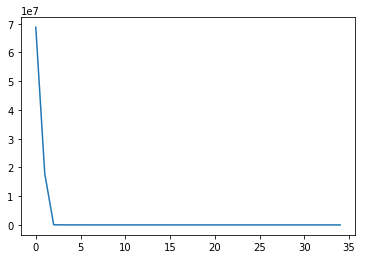

In [120]:
%matplotlib inline
# plt.xlim(xmax=5)
plt.plot(s)

# Decision Tree Regressor

In [214]:
x_train

,start_station_id,end_station_id,subscription_type,start_time,city_zip_code,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,...,wind_dir_degrees,Fog,Fog-Rain,Rain,Rain-Thunderstorm,rain,start_day,end_day,end_time,month
106652,73.0,73.0,0.0,18.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,18.0,9.0
106653,50.0,60.0,0.0,11.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,12.0,9.0
106654,76.0,71.0,0.0,13.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,13.0,9.0
106655,77.0,50.0,1.0,17.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,17.0,9.0
106656,48.0,48.0,0.0,15.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,15.0,9.0
106657,50.0,42.0,0.0,14.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,15.0,9.0
106658,48.0,61.0,0.0,22.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,9.0
106659,57.0,73.0,0.0,10.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,10.0,9.0
106660,60.0,68.0,0.0,20.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,21.0,9.0
106661,54.0,57.0,0.0,13.0,94107.0,74.0,66.0,58.0,60.0,56.0,...,284.0,0.0,0.0,0.0,0.0,0.0,6.0,6.0,13.0,9.0


In [182]:
possible_depth = [i for i in range(1,11)]
for i in possible_depth:
    print i,

1 2 3 4 5 6 7 8 9 10


In [216]:
best_depth = 0
best_precision = 0

number_of_split = 5

kf = KFold(n_splits=number_of_split)

# target_values = data['duration']
# data.drop(labels='duration',axis=1, inplace=True)

for current_depth in possible_depth:
    
    regr_1 = DecisionTreeRegressor(max_depth=current_depth)
    
    precision = 0
    
    for train,test in kf.split(data):

        x_train = data.iloc[train,:]
        y_train = target_values[train]
        
        x_test = data.iloc[test,:]
        y_test = target_values[test]
        
        regr_1.fit(x_train, y_train)

        y_pred = regr_1.predict(x_test)

        precision += sum(np.isclose(y_pred, y_test, 30)) / float(X_train.shape[0])

    precision /= number_of_split
    
    if (precision > best_precision):
        
        best_precision = precision
        best_depth = current_depth

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [194]:
y_train

106652     2954.0
106653     1447.0
106654      400.0
106655      289.0
106656      289.0
106657     1687.0
106658    13260.0
106659     1474.0
106660     1581.0
106661     1070.0
106662      804.0
106663      568.0
106664    17317.0
106665       87.0
106666    25092.0
106667     1201.0
106668      546.0
106669     3456.0
106670      728.0
106671      447.0
106672      267.0
106673     1341.0
106674     1209.0
106675      561.0
106676    17294.0
106677     2469.0
106678      704.0
106679      426.0
106680     1373.0
106681      388.0
           ...   
533230      516.0
533231      519.0
533232      201.0
533233      367.0
533234      184.0
533235      247.0
533236      439.0
533237      429.0
533238      406.0
533239      426.0
533240      172.0
533241        NaN
533242        NaN
533243        NaN
533244        NaN
533245        NaN
533246        NaN
533247        NaN
533248        NaN
533249        NaN
533250        NaN
533251      665.0
533252      374.0
533253      339.0
533254    

In [193]:
from __future__ import division

print 426608/530000

0.804920754717


In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.scatter(x=range(len(y_1)),y=y_1)

In [ ]:
plt.figure(figsize=(15,8))
plt.ylim(0,531240)
plt.scatter(x=range(len(Y_test)),y=Y_test)

In [ ]:
regr_1.score(X,)